# Tensorflow and TensorRT to Frozen model

## Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image as PILImage

# For import utils.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from utils import label_map_util
from utils import visualization_utils as vis_util

import pprint
import time
import cv2

### For Jetson TX2

In [2]:
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


## Variables

### 1.1) ssd_mobilenet_v1_coco_2017_11_17

In [ ]:
# What model to download.
MODEL_NAME = './models/ssd_mobilenet_v1_coco_2017_11_17'
# MODEL_NAME = "faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
OUTPUTS = ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

### 1.2) faster_rcnn_resnet101_kitti_2018_01_28

In [3]:
# What model to download.
MODEL_NAME = './models/faster_rcnn_resnet101_kitti_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
OUTPUTS = ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'kitti_label_map.pbtxt')

### 2)

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
print(PATH_TO_FROZEN_GRAPH)

sub_dir = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
print(sub_dir)

faster_rcnn_resnet101_kitti_2018_01_28/frozen_inference_graph.pb
2019_07_23-16_06_43


## Download Model
from Internet

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [ ]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper Function

#### 1) Function to read ".pb" model (TensorRT model is stored in ".pb")

In [6]:
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

#### 2) Function to load image into numpy array

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

#### 3) Function of showing graph

In [8]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    
    # If no input graph is given, get the default graph
    if graph_def is None:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

#### 4) Showing image

In [9]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg',img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

## Images variables

In [10]:
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
PATH_TO_TEST_IMAGES_DIR = './test_images2'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
pprint.pprint(TEST_IMAGE_PATHS)

In [11]:
PATH_TO_TEST_IMAGES_DIR = './test_images/Test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, file) for file in os.listdir(PATH_TO_TEST_IMAGES_DIR) if file.endswith(('jpg', 'png'))  ]
pprint.pprint(TEST_IMAGE_PATHS)

['./test_images/Test/1505828509427.jpg',
 './test_images/Test/1508415995610.jpg',
 './test_images/Test/1506436717898.jpg',
 './test_images/Test/1506436712612.jpg',
 './test_images/Test/1505828202106.jpg',
 './test_images/Test/1508416337654.jpg',
 './test_images/Test/1508416291542.jpg',
 './test_images/Test/1505828193185.jpg',
 './test_images/Test/1508416338931.jpg',
 './test_images/Test/1508415949797.jpg',
 './test_images/Test/1505828313370.jpg',
 './test_images/Test/1509113541097.jpg',
 './test_images/Test/1509113550023.jpg',
 './test_images/Test/1506437011446.jpg',
 './test_images/Test/1506436701977.jpg',
 './test_images/Test/1508416034989.jpg',
 './test_images/Test/1508416277086.jpg',
 './test_images/Test/1506436787578.jpg',
 './test_images/Test/1506436788321.jpg',
 './test_images/Test/1505828509254.jpg',
 './test_images/Test/1505828199280.jpg',
 './test_images/Test/1506436773784.jpg',
 './test_images/Test/1506437009028.jpg',
 './test_images/Test/1506437063514.jpg',
 './test_images/

## Tensorflow Inference (Detection)

### Load a (frozen) Tensorflow model into memory.
.pb file is in the folder named MODEL_NAME

In [12]:
tf.reset_default_graph()

In [12]:
OUTPUT_NODES = ['num_detections', 'detection_boxes', 'detection_scores','detection_classes']

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        print('Read frozen model')
        tf_graph = read_pb_graph(PATH_TO_FROZEN_GRAPH)
#         show_graph(graph_def=tf_graph)
        tf.import_graph_def(tf_graph, name='')
    
        # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter('./logs/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("\nWrite logs {} success\n".format(sub_dir))
        
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            sess, # session
            tf.get_default_graph().as_graph_def(),# graph+weight from the session
            output_node_names=OUTPUT_NODES)

Read frozen model

Write logs 2019_07_23-14_55_13 success

INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


### Function to inference single image

In [13]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in OUTPUTS:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
#             print('tensor dict')
            pprint.pprint(tensor_dict)
            
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            print("Run Inference")
            print("image size:",image.shape)
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image}) ## Boom here
            print("Finish Inference")
            
            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
        return output_dict

### Inference

In [ ]:
total_time = 0

for idx, image_path in enumerate(TEST_IMAGE_PATHS):
    print(image_path)
    image = PILImage.open(image_path)
    image_np = load_image_into_numpy_array(image)
#     print(image_np.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    t1 = time.time()
    print("--")
    output_dict = run_inference_for_single_image(image_np_expanded, graph)
    print("---")
    t2 = time.time()
    delta_time = t2 - t1
    total_time += delta_time
    
#     print(output_dict)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    print("----")
    # Showing image
    img_name = image_path.replace('Test','Detected')
    if img_name == image_path:
        img_name = "./test_images2/%d.jpg"%idx
    print(idx,'- Saving images:', img_name, ",size:",image_np.shape, "used time:", delta_time)
    im = PILImage.fromarray(image_np, mode="RGB")
#     im.save("detected_images/"+img_name)
    im.save(img_name)
#     cv2.imwrite("./detected_images/"+idx+".jpg",image_np)
#     imshow(image_np)
#     break
    
print("Total time:",total_time)

./test_images/Test/1505828509427.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
0 - Saving images: ./test_images/Detected/1505828509427.jpg ,size: (330, 1240, 3) used time: 15.846187829971313
./test_images/Test/1508415995610.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
-

Finish Inference
---
----
14 - Saving images: ./test_images/Detected/1506436701977.jpg ,size: (330, 1240, 3) used time: 10.788934469223022
./test_images/Test/1508416034989.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
15 - Saving images: ./test_images/Detected/1508416034989.jpg ,size: (330, 1240, 3) used time: 10.344489336013794
./test_images/Test/1508416277086.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_d

Finish Inference
---
----
29 - Saving images: ./test_images/Detected/1508142452632.jpg ,size: (330, 1240, 3) used time: 12.469448328018188
./test_images/Test/1507735233983_1.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
30 - Saving images: ./test_images/Detected/1507735233983_1.jpg ,size: (330, 1240, 3) used time: 12.360379934310913
./test_images/Test/1507735193303_1.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 

Finish Inference
---
----
44 - Saving images: ./test_images/Detected/1506437081499.jpg ,size: (330, 1240, 3) used time: 12.034066677093506
./test_images/Test/1505828513589.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
45 - Saving images: ./test_images/Detected/1505828513589.jpg ,size: (330, 1240, 3) used time: 12.507400274276733
./test_images/Test/1509113523505.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_d

Finish Inference
---
----
59 - Saving images: ./test_images/Detected/1506437010360.jpg ,size: (330, 1240, 3) used time: 12.332282304763794
./test_images/Test/1506436787232.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
60 - Saving images: ./test_images/Detected/1506436787232.jpg ,size: (330, 1240, 3) used time: 12.256538391113281
./test_images/Test/1505828321822.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_d

Finish Inference
---
----
74 - Saving images: ./test_images/Detected/1506437019853.jpg ,size: (330, 1240, 3) used time: 12.102699518203735
./test_images/Test/1506436696505.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
75 - Saving images: ./test_images/Detected/1506436696505.jpg ,size: (330, 1240, 3) used time: 12.946593046188354
./test_images/Test/1506436781408.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_d

Finish Inference
---
----
89 - Saving images: ./test_images/Detected/1505828314195.jpg ,size: (330, 1240, 3) used time: 14.73873519897461
./test_images/Test/1508416045951.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
90 - Saving images: ./test_images/Detected/1508416045951.jpg ,size: (330, 1240, 3) used time: 13.105628967285156
./test_images/Test/1506436789328.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_de

Finish Inference
---
----
104 - Saving images: ./test_images/Detected/1508416122502.jpg ,size: (330, 1240, 3) used time: 12.864492177963257
./test_images/Test/1505828519065.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
105 - Saving images: ./test_images/Detected/1505828519065.jpg ,size: (330, 1240, 3) used time: 11.86536431312561
./test_images/Test/1508142389458.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_

Finish Inference
---
----
119 - Saving images: ./test_images/Detected/1506436994362.jpg ,size: (330, 1240, 3) used time: 9.415473461151123
./test_images/Test/1506436749672.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
120 - Saving images: ./test_images/Detected/1506436749672.jpg ,size: (330, 1240, 3) used time: 10.970699310302734
./test_images/Test/1508416228443.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_

Finish Inference
---
----
134 - Saving images: ./test_images/Detected/1508416310080.jpg ,size: (330, 1240, 3) used time: 11.177696228027344
./test_images/Test/1508415969140.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
135 - Saving images: ./test_images/Detected/1508415969140.jpg ,size: (330, 1240, 3) used time: 10.380226135253906
./test_images/Test/1506436729680.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num

Finish Inference
---
----
149 - Saving images: ./test_images/Detected/1508143046188.jpg ,size: (330, 1240, 3) used time: 11.412063837051392
./test_images/Test/1505828496942.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
150 - Saving images: ./test_images/Detected/1505828496942.jpg ,size: (330, 1240, 3) used time: 12.873692274093628
./test_images/Test/1505828495053.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num

Finish Inference
---
----
164 - Saving images: ./test_images/Detected/1507729370918_1.jpg ,size: (330, 1240, 3) used time: 11.31235957145691
./test_images/Test/1506436394452.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
165 - Saving images: ./test_images/Detected/1506436394452.jpg ,size: (330, 1240, 3) used time: 9.211719512939453
./test_images/Test/1505828508153.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num

Finish Inference
---
----
179 - Saving images: ./test_images/Detected/1507706098282_1.jpg ,size: (330, 1240, 3) used time: 10.775475263595581
./test_images/Test/1506436394593.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
180 - Saving images: ./test_images/Detected/1506436394593.jpg ,size: (330, 1240, 3) used time: 11.65030574798584
./test_images/Test/1505828200317.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'nu

Finish Inference
---
----
194 - Saving images: ./test_images/Detected/1506436691690.jpg ,size: (330, 1240, 3) used time: 11.52943730354309
./test_images/Test/1508416294039.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)
Finish Inference
---
----
195 - Saving images: ./test_images/Detected/1508416294039.jpg ,size: (330, 1240, 3) used time: 12.931363821029663
./test_images/Test/1506436723797.jpg
--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_

### Show deteced images

In [19]:
PATH_TO_DETECTED_IMAGES_DIR = './test_images2'
DETECTED_IMAGE_PATHS = [ os.path.join(PATH_TO_DETECTED_IMAGES_DIR, file) for file in os.listdir(PATH_TO_DETECTED_IMAGES_DIR) if file.endswith("jpg") ]
print(DETECTED_IMAGE_PATHS)

['./test_images2/image1.jpg', './test_images2/0.jpg', './test_images2/image2.jpg', './test_images2/1.jpg']


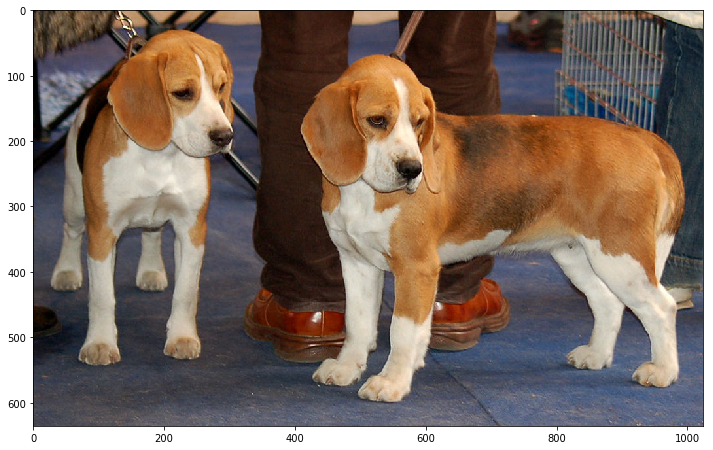

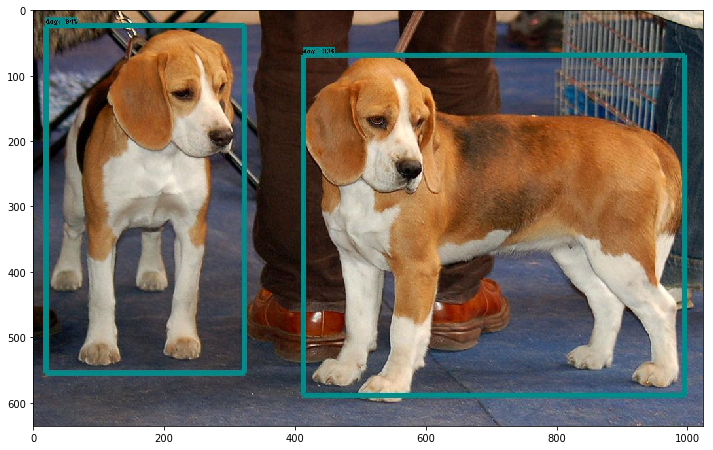

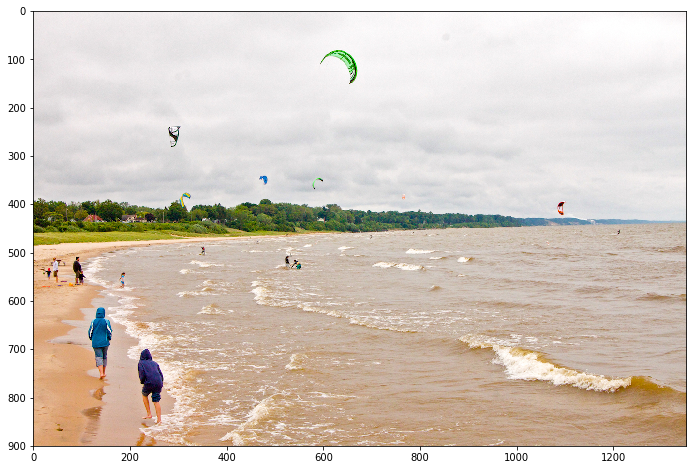

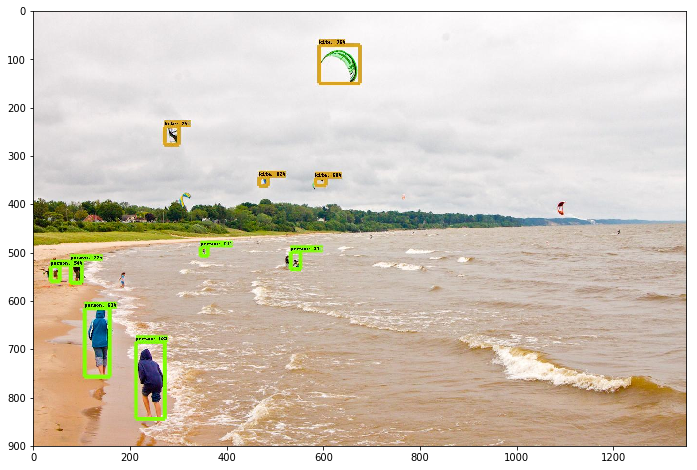

In [20]:
for idx, image_path in enumerate(DETECTED_IMAGE_PATHS):
    image = PILImage.open(image_path)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(np.asarray(image))

In [ ]:
# Or...
plt.figure(figsize=IMAGE_SIZE)
COLS = 1
ROWS = len(DETECTED_IMAGE_PATHS) / COLS+1

for idx, image_path in enumerate(DETECTED_IMAGE_PATHS):
    image = PILImage.open(image_path)
#     image.show()
    plt.subplot(ROWS, COLS, idx+1 )
    plt.imshow(np.asarray(image))

## Interferencing With TensorRT

### Optimize to TensorRT Model

In [ ]:
%%time
# outputs = [out.op.name for out in model.outputs] # name of output layer
BATCH_SIZE = 256

# convert (optimize) frozen model to TensorRT model
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,# frozen model
    outputs=OUTPUT_NODES,
    max_batch_size=BATCH_SIZE,# specify your max batch size
    max_workspace_size_bytes=2*(10**9),# specify the max workspace
    precision_mode="FP32") # precision, can be "FP32" (32 floating point precision) or "FP16"

In [15]:
#write the TensorRT model to be used later for inference
pb_trt_filename = "trt_frozen_graph-"+sub_dir+".pb"
# PATH_TO_TRT_FROZEN_GRAPH = MODEL_NAME+ "/" + pb_trt_filename
PATH_TO_TRT_FROZEN_GRAPH = MODEL_NAME+"/trt_frozen_graph-2019_07_18-17_23_40.pb"
print(PATH_TO_TRT_FROZEN_GRAPH)

ssd_mobilenet_v1_coco_2017_11_17/trt_frozen_graph-2019_07_18-17_23_40.pb


In [ ]:
with gfile.FastGFile(PATH_TO_TRT_FROZEN_GRAPH, 'wb') as f:
    f.write(trt_graph.SerializeToString())
print(pb_trt_filename + " is successfully stored!")

### Load TensorRT graph

In [22]:
tf.reset_default_graph()

In [16]:
trt_detection_graph = tf.Graph()
with trt_detection_graph.as_default():
    with tf.Session() as sess:
        print('Read TensorRT frozen model')
        trt_graph = read_pb_graph(PATH_TO_TRT_FROZEN_GRAPH)
#         show_graph(graph_def=tf_graph)
        tf.import_graph_def(trt_graph, name='')
#         print([node.name for node in trt_graph.node])
        
        # write to tensorboard (check tensorboard for each op names)
#         writer = tf.summary.FileWriter('./trt_logs/'+sub_dir)
#         writer.add_graph(sess.graph)
#         writer.flush()
#         writer.close()
#         print("\nWrite trt_logs success")

# print([node.name for node in trt_detection_graph.get_operations()])

Read TensorRT frozen model


### Inference

In [ ]:
trt_total_time = 0

for idx, image_path in enumerate(TEST_IMAGE_PATHS):
    image = PILImage.open(image_path)
    image_np = load_image_into_numpy_array(image)
#     print(image_np.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    t1 = time.time()
    print("--")
    output_dict = run_inference_for_single_image(image_np_expanded, trt_detection_graph)
    print("---")
    t2 = time.time()
    delta_time = t2 - t1
    trt_total_time += delta_time
    
#     print(output_dict)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    # Showing image
    img_name = "%d.jpg"%idx
    print(idx,'- Saving images:', img_name, ",size:",image_np.shape, "used time:", delta_time)
    im = PILImage.fromarray(image_np, mode="RGB")
    im.save("detected_images/"+img_name)
#     cv2.imwrite("./detected_images/"+idx+".jpg",image_np)
#     imshow(image_np)
    if(idx==10):
        break
    
print("Total time:",trt_total_time)

--
{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=(?, 100, 4) dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=(?, 100) dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=(?, 100) dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=(?,) dtype=float32>}
Run Inference
image size: (1, 330, 1240, 3)


## Different Time

In [ ]:
print("Detection time: ", total_time)
print("With TensorRT Detection time: ", trt_total_time)
print("Different time (TensorRT faster):", total_time - trt_total_time)
print("TensorRT improvement:", total_time/trt_total_time, "times")